!!!Сохранение и загрузка моделей, решение загадки в notebook https://github.com/ivan-shargin/cvr_course/blob/main/notebooks/mnist_sem2.ipynb

# Домашнее задание 5

Ссылка на семинар: https://colab.research.google.com/drive/1_G8kdmhtokmAUeMsSrl1IKqIs3_FEbeK?usp=sharing

Не забудьте поставить видеокарту в качестве аппаратного ускорителя :)

### Сохранение и загрузка 
Решение этой части в notebook https://github.com/ivan-shargin/cvr_course/blob/main/notebooks/mnist_sem2.ipynb

[3 балла] 

Сделайте сохранение моделей после обучения (в формате .pth). В случае маленьких сетей на маленьких данных в этом нет необходимости, но в других случаях можно сохранять версию модели (checkpoint) каждые несколько (к примеру 5) эпох. Сделайте и протестируйте загрузку моделей для задачи классификации рукописных цифр.

### Сверточная сеть на CIFAR-10

[5 баллов]

Решите задачу классификации на другом датасете - CIFAR-10 https://en.wikipedia.org/wiki/CIFAR-10
В примерах к Pytorch есть полное решение этой задачи, но попробуйте придумать его самостоятельно. Этот датасет отличается от mnist тем, что изображения в нём имеют размер не 28x28, а 32x32x3, то есть они трёхканальные, "цветные". Для того, чтобы сеть заработала и начала хотя бы как-то учиться, нужно сделать так, чтобы размеры (shapes) тензоров на выходе предыдущего слоя совпадали с размером тензоров на входе следующего слоя.

### Классификация на своих картинках

[6 баллов]

Запустите распознавание цифр на самостоятельно записанных данных. Можно использовать фотографию листочка, можно просто нарисовать их в пейнте. Чтобы все заработало, нужнро во-первых помнить, что сеть, созданная для работы с mnist, принимает на вход одноканальные картинки 28x28, а во-вторых учесть, что границы цифр в обучающих данных не резкие, в процессе их подготовки был применён антиалеасинг.

### Загадка
Решение этой части в notebook https://github.com/ivan-shargin/cvr_course/blob/main/notebooks/mnist_sem2.ipynb

Доп.задача 1 [5 баллов]

Найдите, почему при обучении свёрточной сети (Conv_net в семинаре) test loss всё время меньше train loss-а. Напишите, почему так получается, исправьте ошибку, если она есть. Обратите внимание, что при обучении Simple_net такого не наблюдается.

### Ответ на загадку. 
Грубая ошибка была в том, что в изначальном коде сеть не просто считала loss на тестовых данных но еще и обучалась на них, что недопустимо. Кроме того, test loss меньше train loss, так как train loss считался перед эпохой обучения, а test loss после той же эпохи. Соответственно, мы должны сохранять loss после back propagation, т.е. должны измерять loss еще и после optimizer.step(). Это я и сделал. 
Еще одно решение заключается в том, чтобы сначала считать test loss а уже потом train loss, но тогда каждый график относился бы к более ранней эпохе.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
batch_size = 64
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

Files already downloaded and verified


target tensor(5)


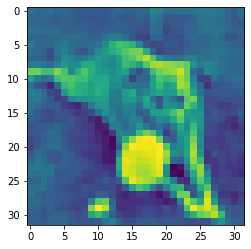

In [3]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import cv2

for data, target in train_loader:
    for i in range (1):
        print ("target", target [i])
        img = data [i, 0, :, :]
        plt.imshow (img)
        plt.show ()

#         #kernel = np.ones((3, 3),np.float32)
#         kernel = np.array([[-1, 0, 1]],np.float32)

#         #print (type (img))
#         convolved = cv2.filter2D(img.detach().cpu().numpy(),-1,kernel)
#         plt.imshow (convolved)
#         plt.show ()

    break

In [4]:
class Simple_net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Simple_net, self).__init__()
        
        self.fc1 = nn.Linear(32**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #torch.Size([64, 3, 32, 32])
        x = self.conv1(x)
        #torch.Size([64, 32, 30, 30])
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        #torch.Size([64, 64, 14, 14])
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #torch.Size([64, 12544])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        output = F.log_softmax(x, dim=1)
        #torch.Size([64, 10])
        return output

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive, train=True):
    train_loss = 0

    if (train):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            #measure loss for archive after backward propagation .
            output = model(data)
            loss = F.nll_loss(output, target) 
            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    
    else:
        model.eval()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
         
            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

def test(model, device, test_loader, loss_archive):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = test_loss / len(test_loader)
    loss_archive.append (test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

C:\Users\ishar\anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.250217
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.097310
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.106657
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.753326
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.807695
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.632306
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.916753
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.608488

Test set: Average loss: 1.6294, Accuracy: 4734/10000 (47%)



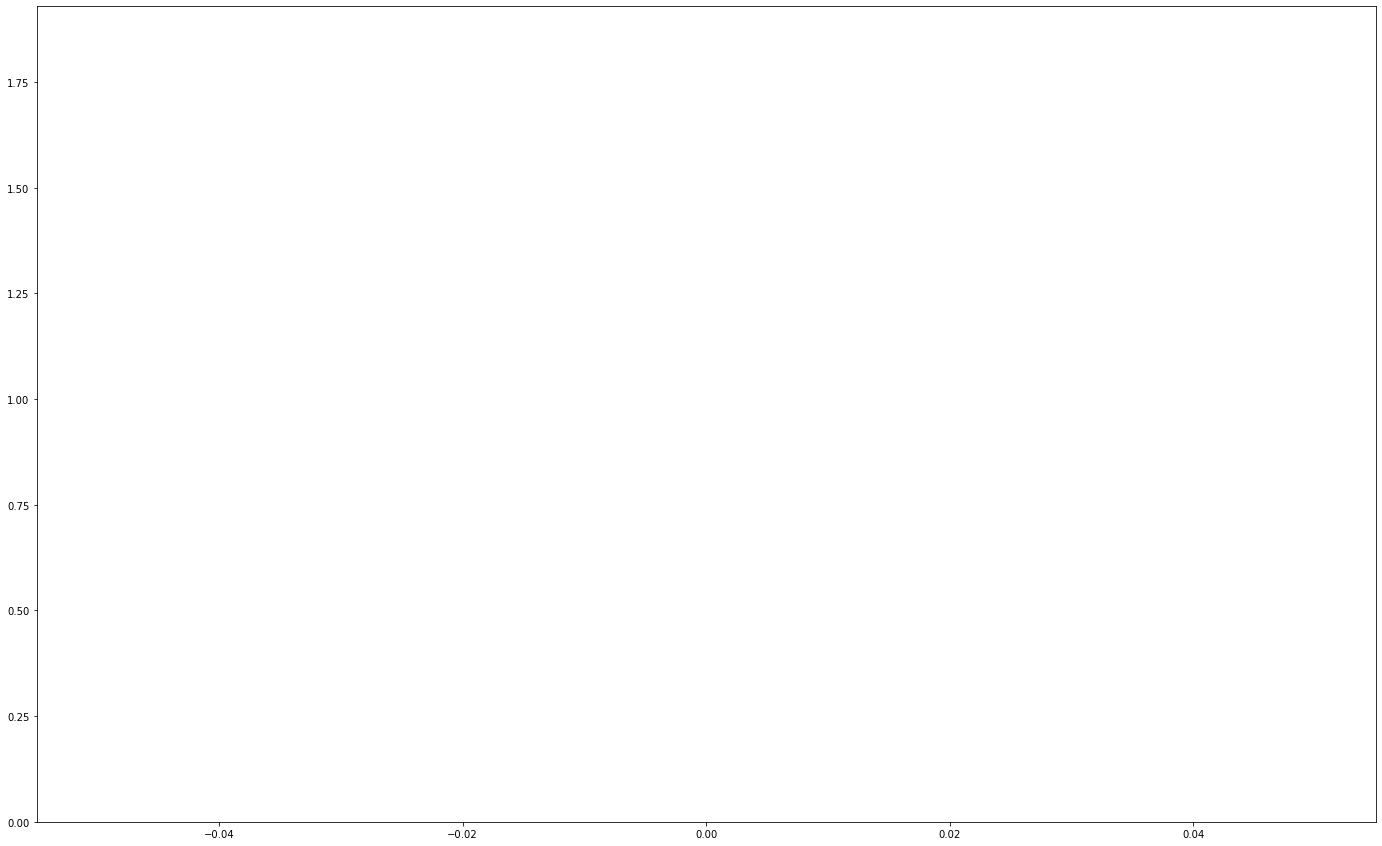

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.742477
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.980643
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.854386
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.778167
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.645180
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.864007
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.644028
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.757435

Test set: Average loss: 1.4254, Accuracy: 5710/10000 (57%)



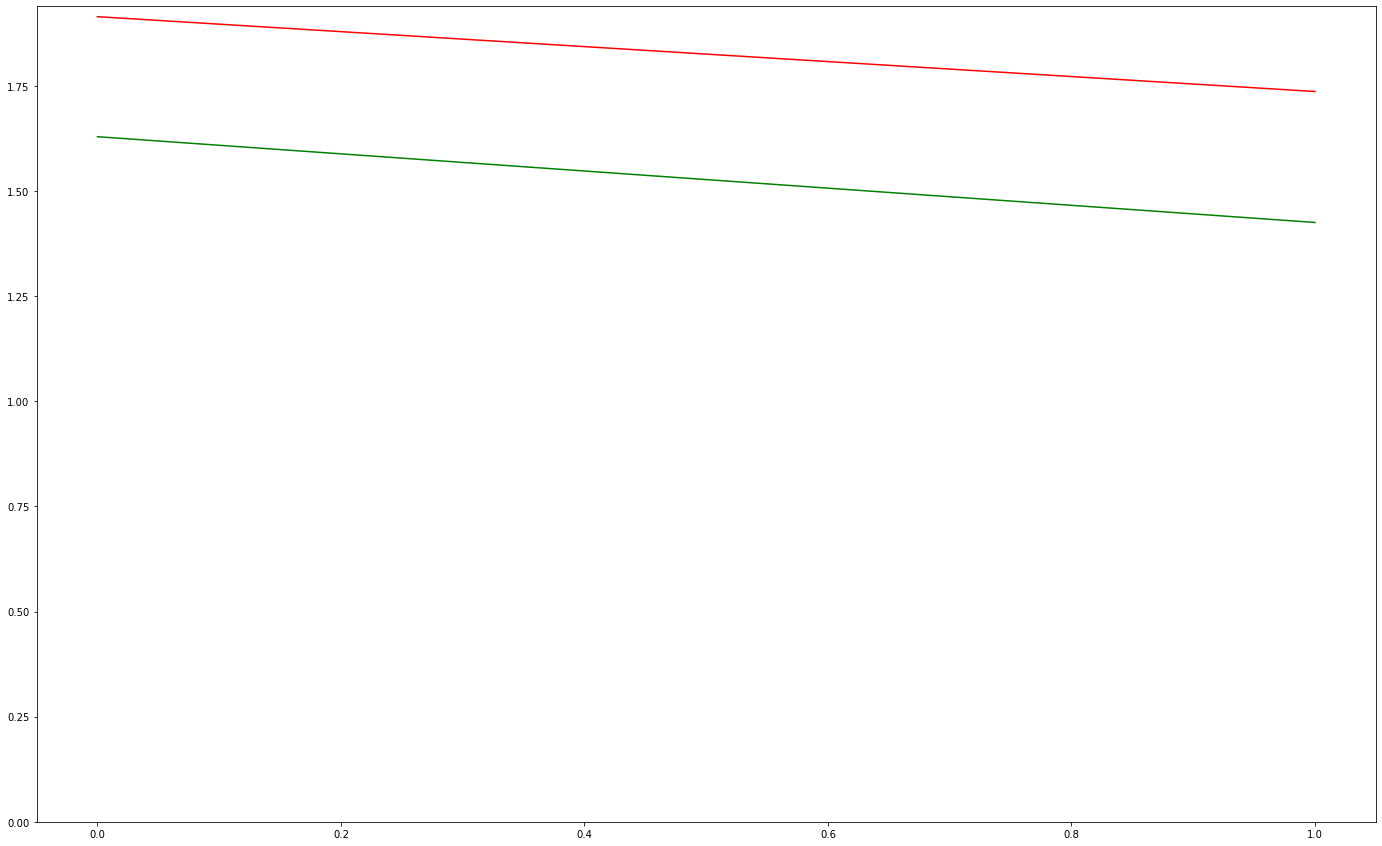

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.586663
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.599172
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.411038
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.720252
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.614539
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.533539
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.573312
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.832882

Test set: Average loss: 1.3422, Accuracy: 5938/10000 (59%)



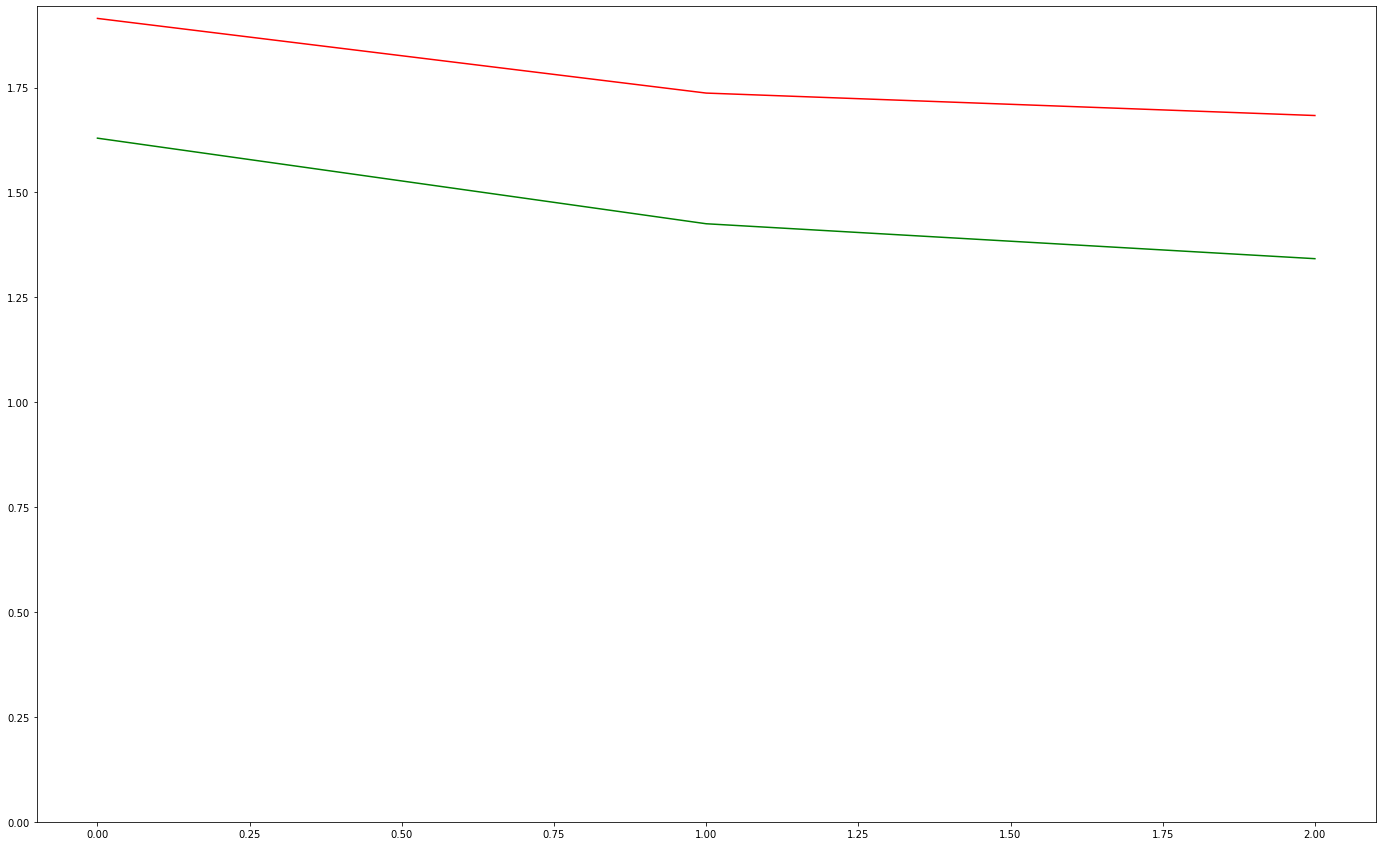

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.517333
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.549492
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.467649
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.604332
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.560089
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.574649
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.686991
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.727494

Test set: Average loss: 1.2873, Accuracy: 6097/10000 (61%)



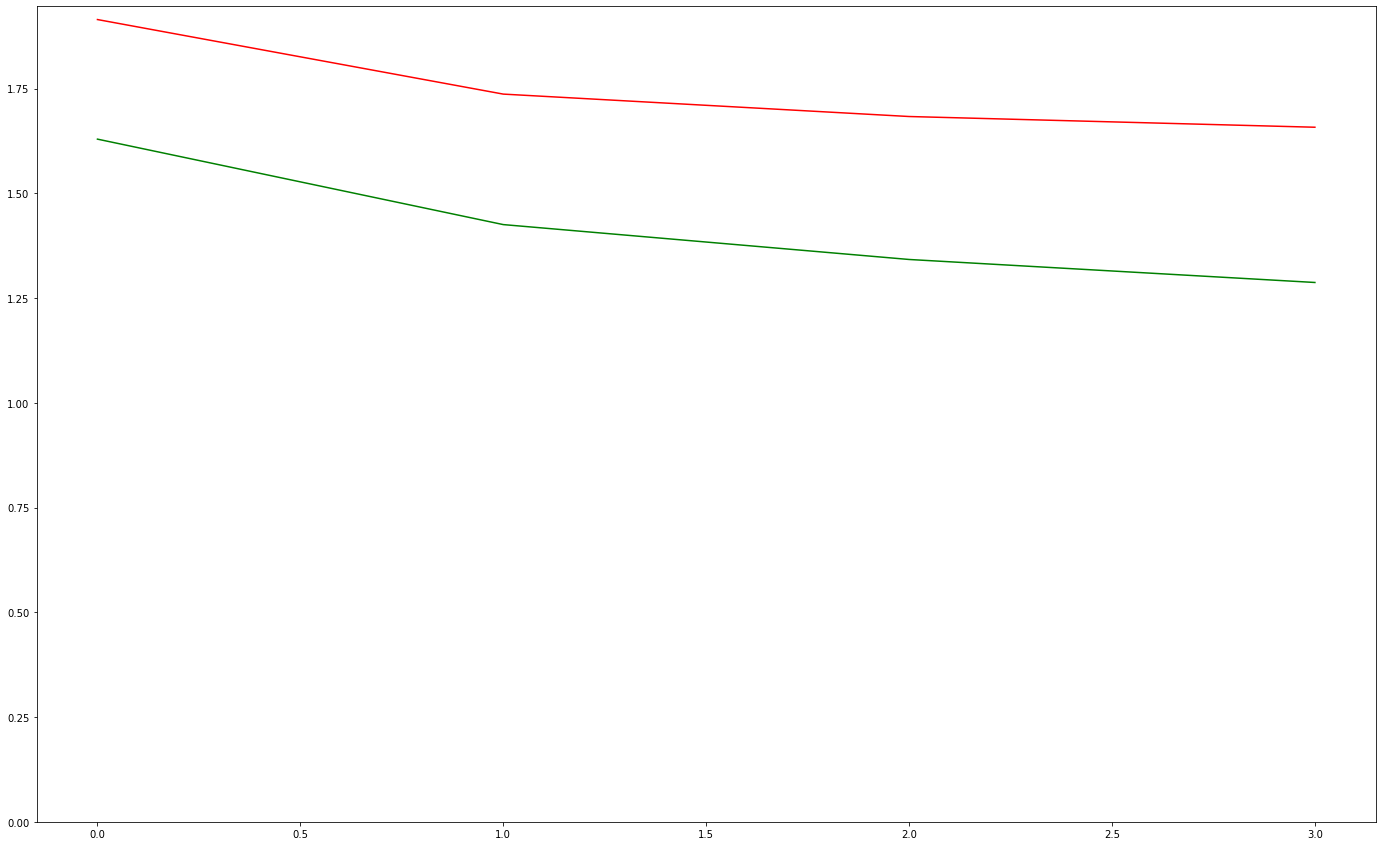

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.653916
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.634566
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.532822
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.661064
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.558911
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.571676
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.651300
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.504621

Test set: Average loss: 1.2627, Accuracy: 6248/10000 (62%)



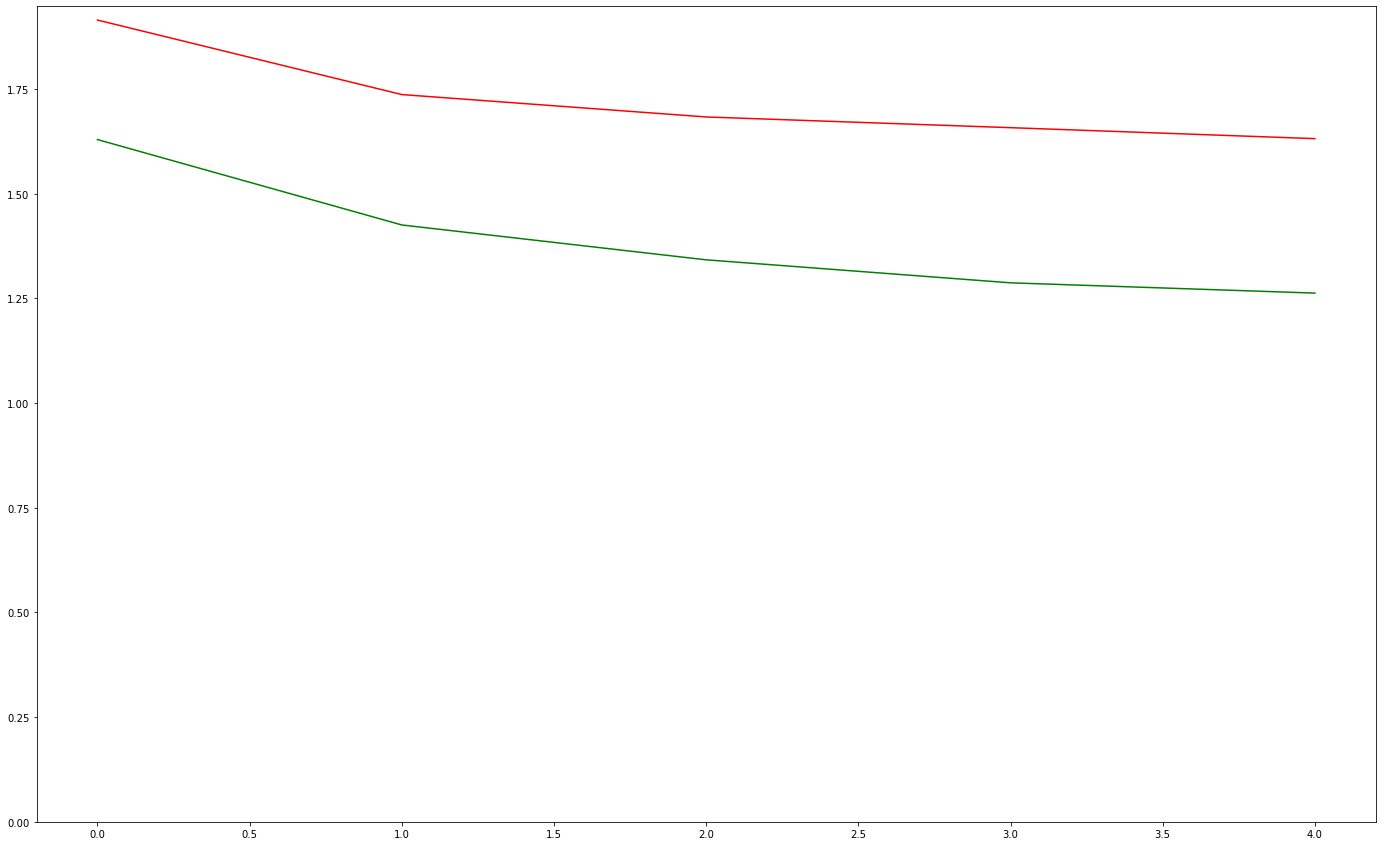

In [6]:

epochs          = 5
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")


model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    
    test(model, device, test_loader, test_loss)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)

torch.save(model, "cifar_first_5_epochs.pth")

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.757796
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.512763
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.742824
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.672489
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.655040
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.556852
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.416483
Train Epoch: 6 [44800/50000 (90%)]	Loss: 1.473340

Test set: Average loss: 1.2469, Accuracy: 6202/10000 (62%)



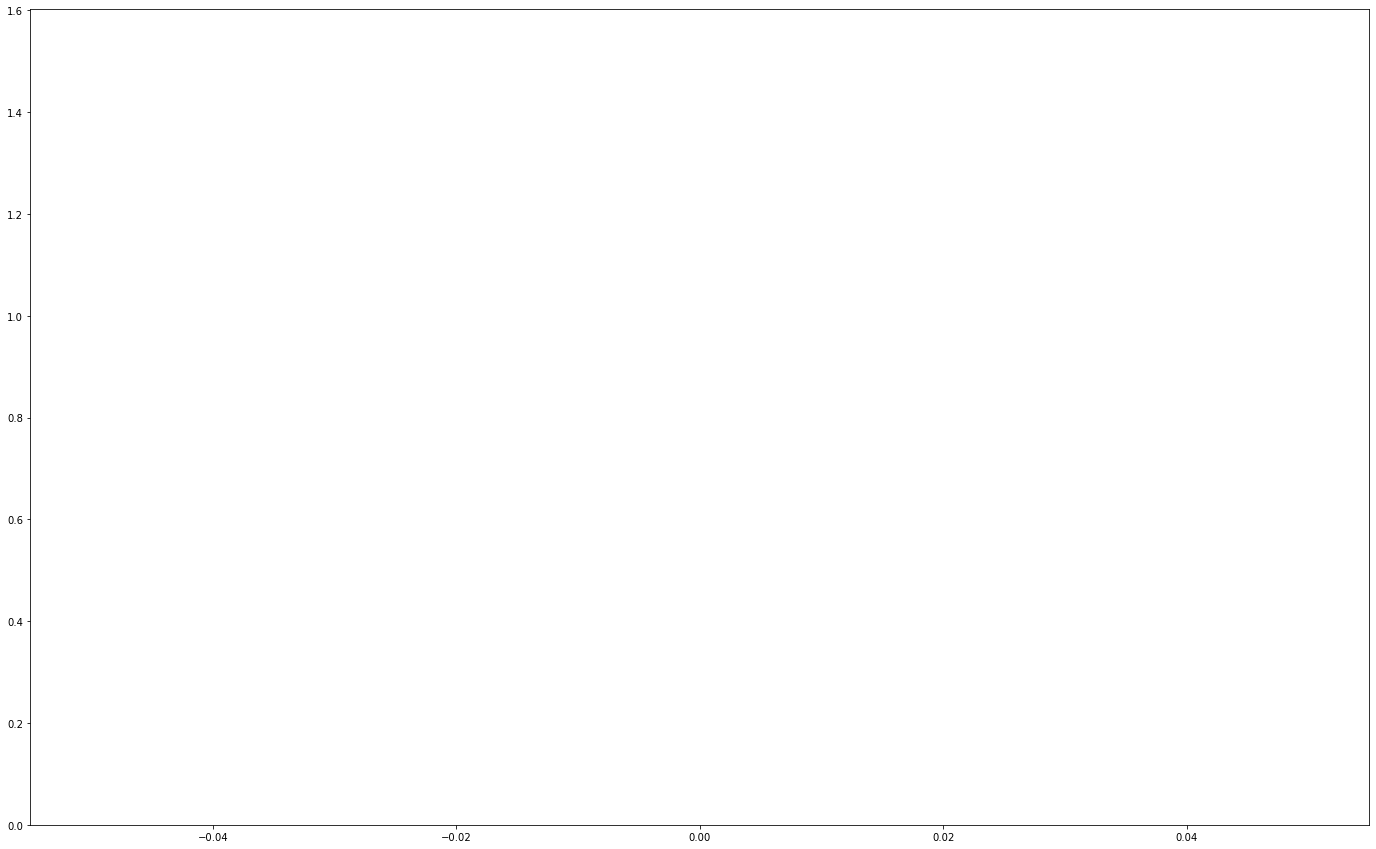

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.470799
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.416280
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.566399
Train Epoch: 7 [19200/50000 (38%)]	Loss: 1.339970
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.399655
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.524340
Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.495299
Train Epoch: 7 [44800/50000 (90%)]	Loss: 1.640331

Test set: Average loss: 1.1674, Accuracy: 6373/10000 (64%)



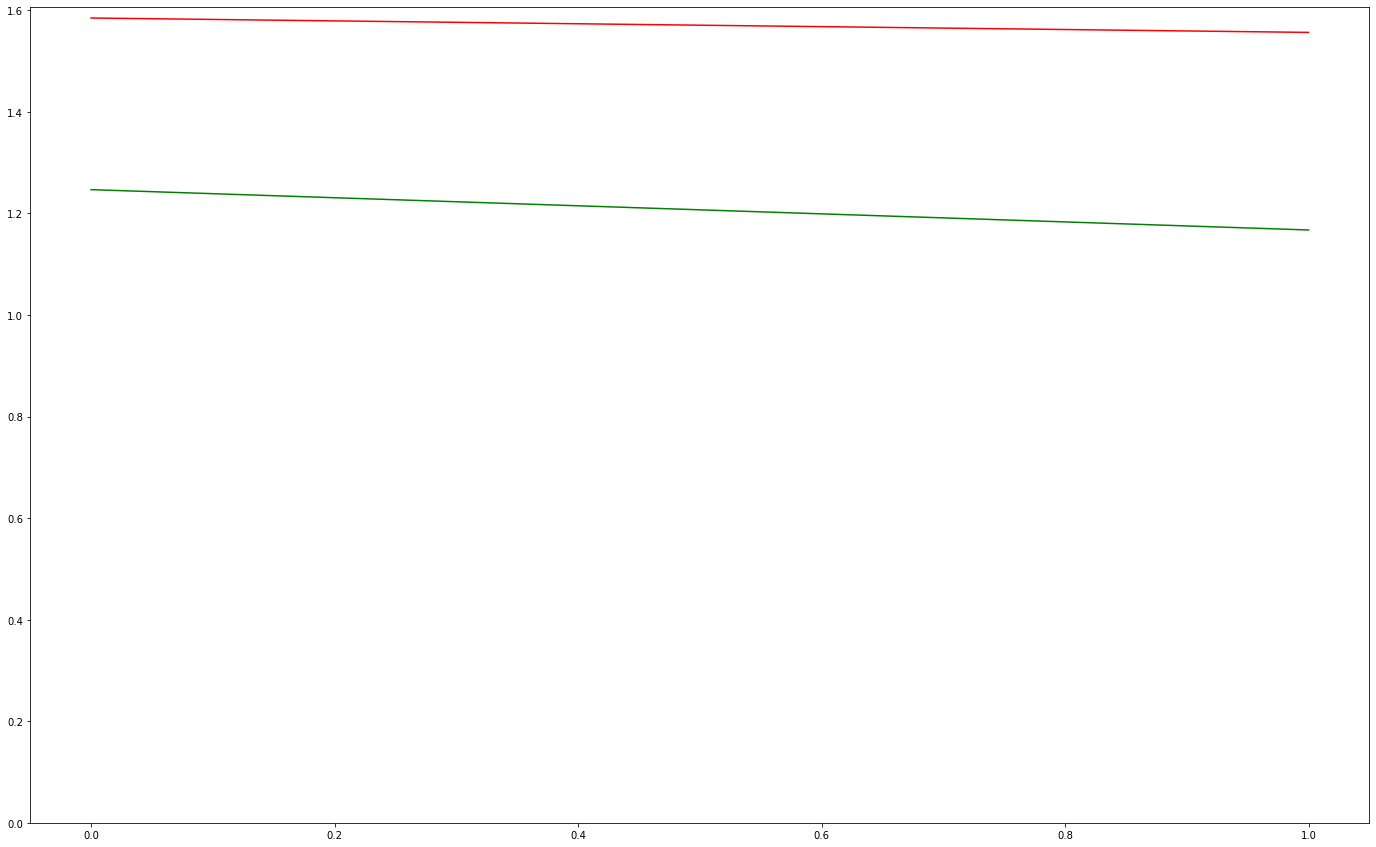

Train Epoch: 8 [0/50000 (0%)]	Loss: 1.255494
Train Epoch: 8 [6400/50000 (13%)]	Loss: 1.372871
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.528945
Train Epoch: 8 [19200/50000 (38%)]	Loss: 1.568579
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.634535
Train Epoch: 8 [32000/50000 (64%)]	Loss: 1.467061
Train Epoch: 8 [38400/50000 (77%)]	Loss: 1.479300
Train Epoch: 8 [44800/50000 (90%)]	Loss: 1.230842

Test set: Average loss: 1.1277, Accuracy: 6591/10000 (66%)



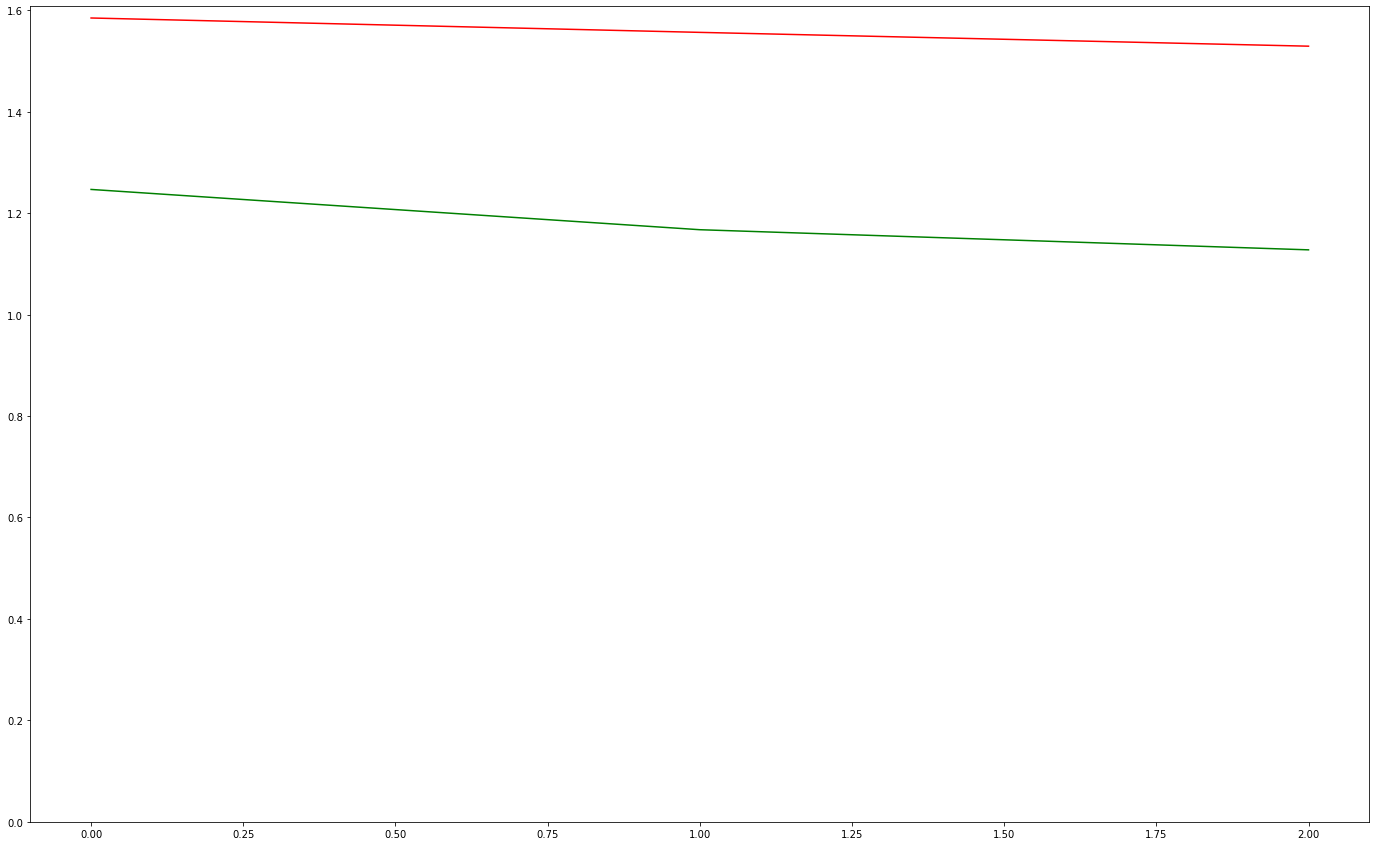

Train Epoch: 9 [0/50000 (0%)]	Loss: 1.439756
Train Epoch: 9 [6400/50000 (13%)]	Loss: 1.510996
Train Epoch: 9 [12800/50000 (26%)]	Loss: 1.507210
Train Epoch: 9 [19200/50000 (38%)]	Loss: 1.400038
Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.197495
Train Epoch: 9 [32000/50000 (64%)]	Loss: 1.528817
Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.350729
Train Epoch: 9 [44800/50000 (90%)]	Loss: 1.497073

Test set: Average loss: 1.1031, Accuracy: 6687/10000 (67%)



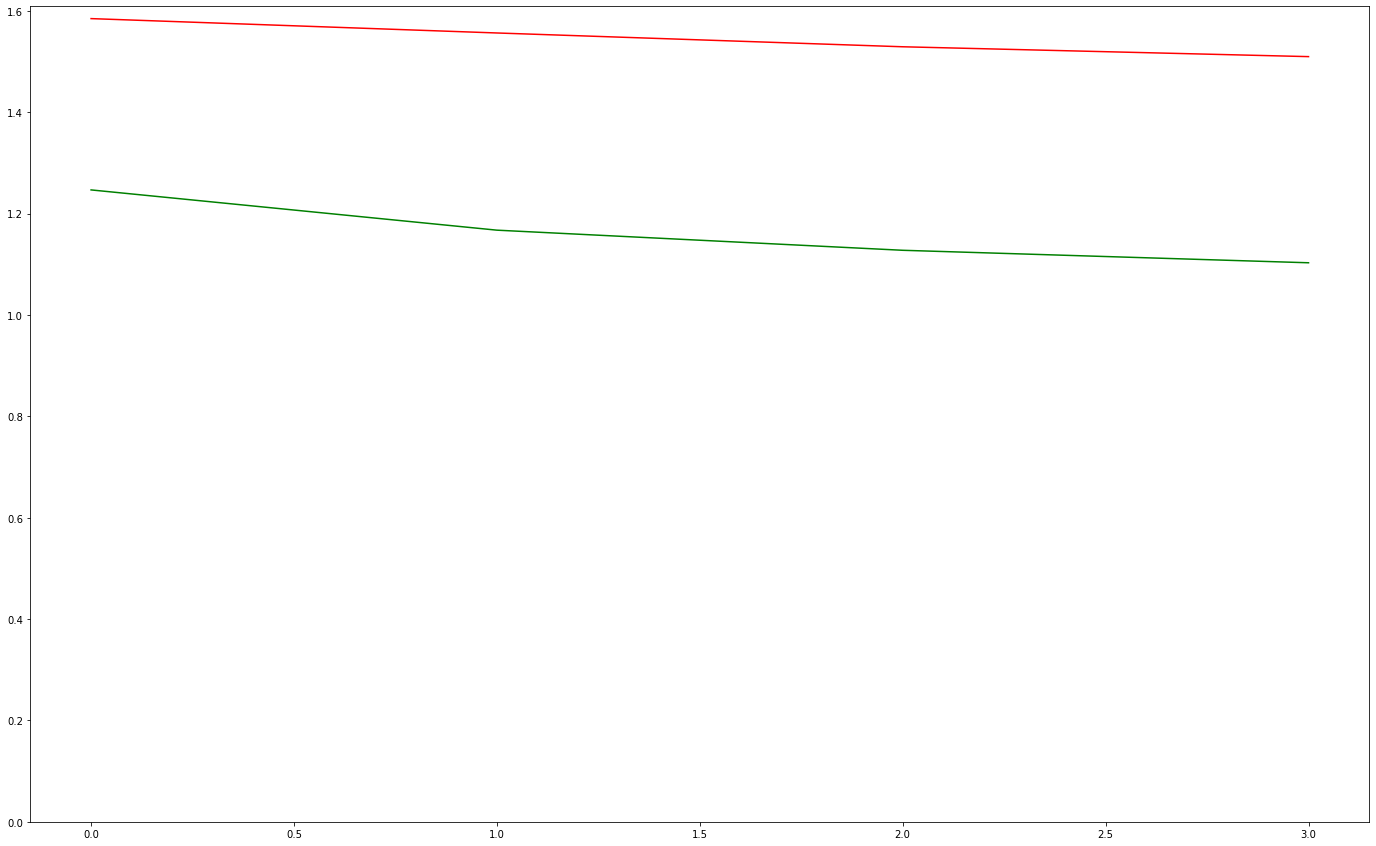

Train Epoch: 10 [0/50000 (0%)]	Loss: 1.384346
Train Epoch: 10 [6400/50000 (13%)]	Loss: 1.664782
Train Epoch: 10 [12800/50000 (26%)]	Loss: 1.631774
Train Epoch: 10 [19200/50000 (38%)]	Loss: 1.261743
Train Epoch: 10 [25600/50000 (51%)]	Loss: 1.451364
Train Epoch: 10 [32000/50000 (64%)]	Loss: 1.576275
Train Epoch: 10 [38400/50000 (77%)]	Loss: 1.480080
Train Epoch: 10 [44800/50000 (90%)]	Loss: 1.499921

Test set: Average loss: 1.0752, Accuracy: 6726/10000 (67%)



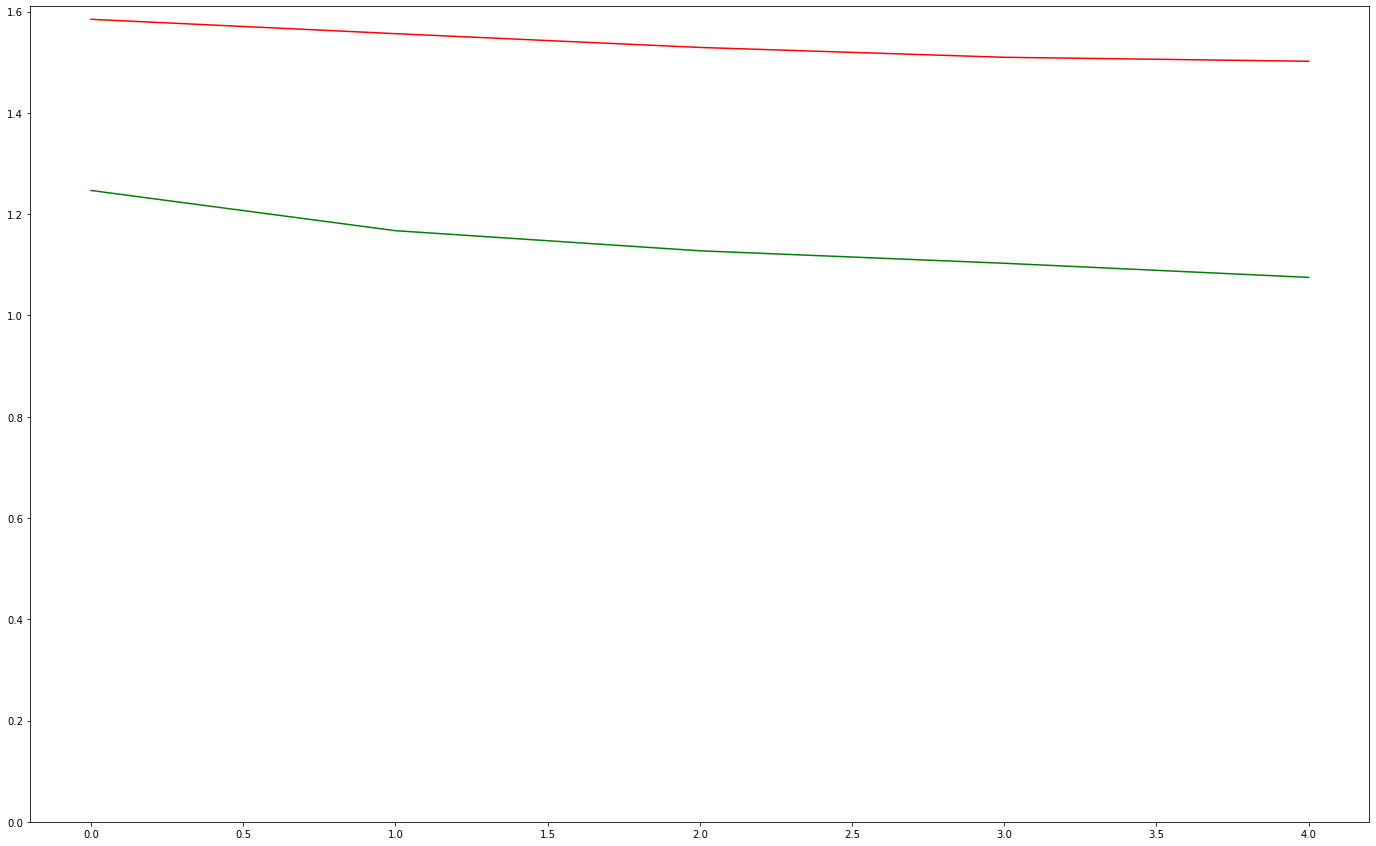

In [7]:
model = torch.load("cifar_first_5_epochs.pth")
epochs          = 10
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(6, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    
    test(model, device, test_loader, test_loss)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)

torch.save(model, "cifar_first_10_epochs.pth")

Train Epoch: 11 [0/50000 (0%)]	Loss: 1.671332
Train Epoch: 11 [6400/50000 (13%)]	Loss: 1.473194
Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.640590
Train Epoch: 11 [19200/50000 (38%)]	Loss: 1.662974
Train Epoch: 11 [25600/50000 (51%)]	Loss: 1.559487
Train Epoch: 11 [32000/50000 (64%)]	Loss: 1.464900
Train Epoch: 11 [38400/50000 (77%)]	Loss: 1.267236
Train Epoch: 11 [44800/50000 (90%)]	Loss: 1.394246

Test set: Average loss: 1.1236, Accuracy: 6232/10000 (62%)



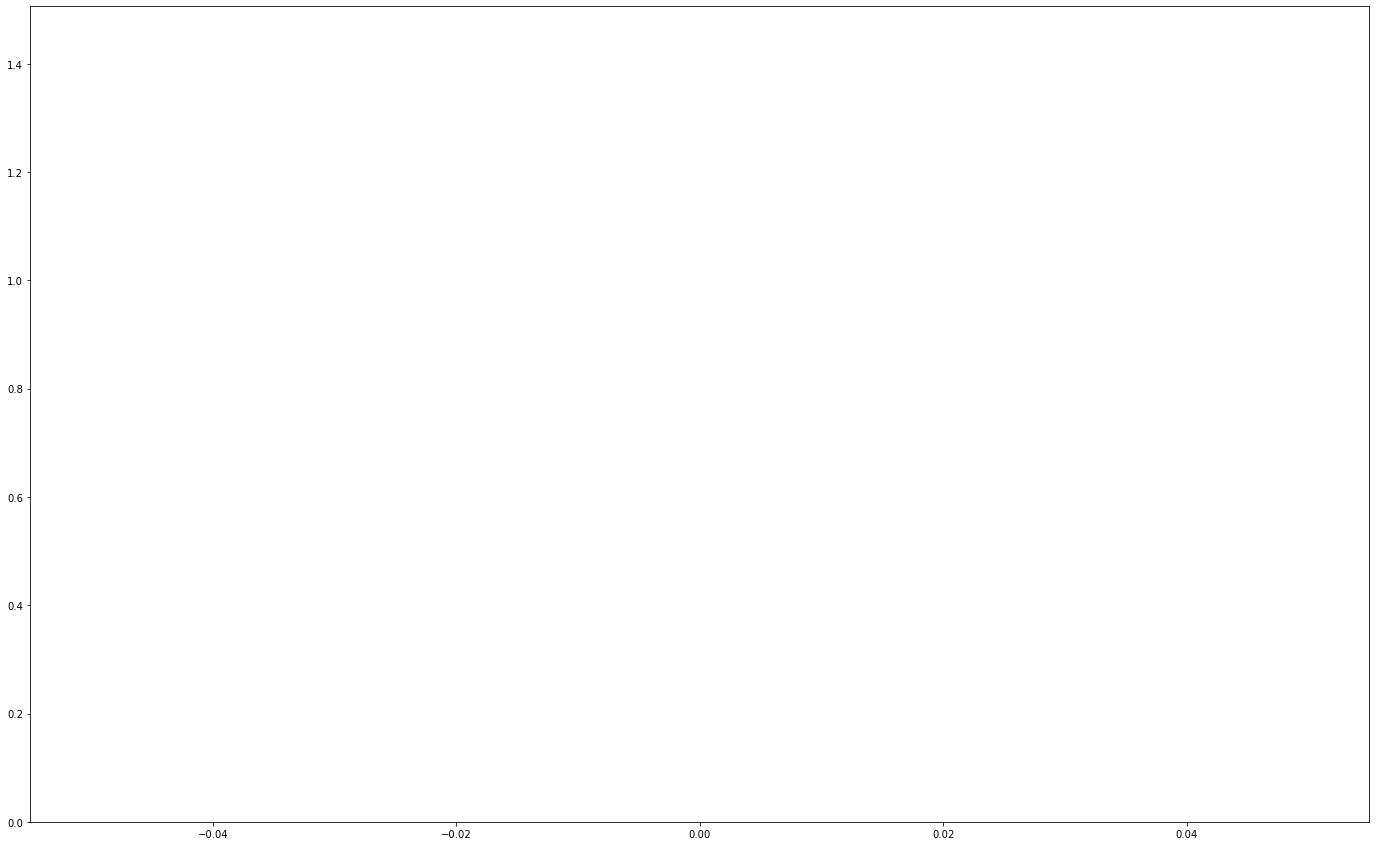

Train Epoch: 12 [0/50000 (0%)]	Loss: 1.273539
Train Epoch: 12 [6400/50000 (13%)]	Loss: 1.322586
Train Epoch: 12 [12800/50000 (26%)]	Loss: 1.504491
Train Epoch: 12 [19200/50000 (38%)]	Loss: 1.253897
Train Epoch: 12 [25600/50000 (51%)]	Loss: 1.306253
Train Epoch: 12 [32000/50000 (64%)]	Loss: 1.382029
Train Epoch: 12 [38400/50000 (77%)]	Loss: 1.443542
Train Epoch: 12 [44800/50000 (90%)]	Loss: 1.614056

Test set: Average loss: 1.0763, Accuracy: 6404/10000 (64%)



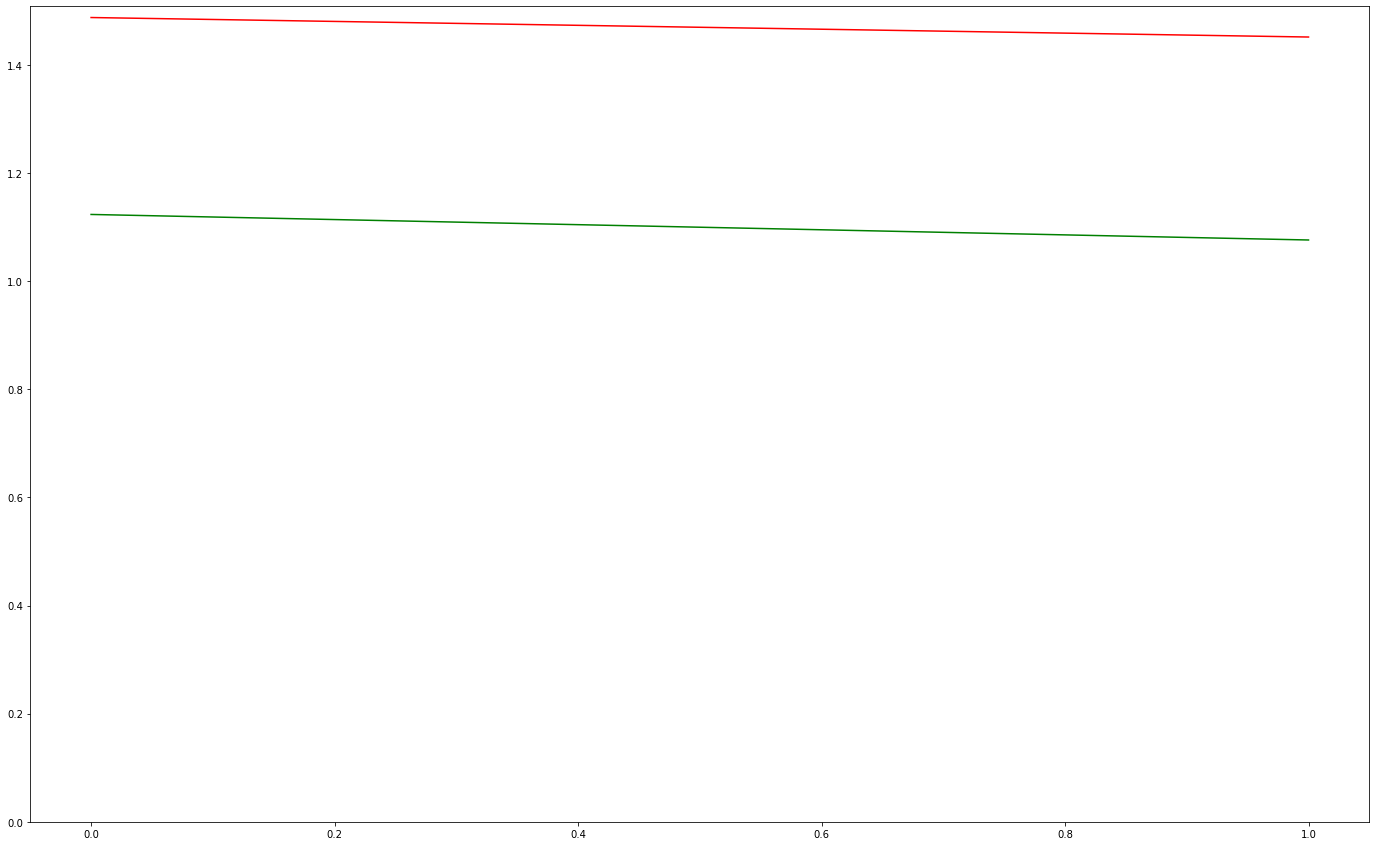

Train Epoch: 13 [0/50000 (0%)]	Loss: 1.266399
Train Epoch: 13 [6400/50000 (13%)]	Loss: 1.299290
Train Epoch: 13 [12800/50000 (26%)]	Loss: 1.359978
Train Epoch: 13 [19200/50000 (38%)]	Loss: 1.374170
Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.429448
Train Epoch: 13 [32000/50000 (64%)]	Loss: 1.349372
Train Epoch: 13 [38400/50000 (77%)]	Loss: 1.354571
Train Epoch: 13 [44800/50000 (90%)]	Loss: 1.115983

Test set: Average loss: 1.0000, Accuracy: 6712/10000 (67%)



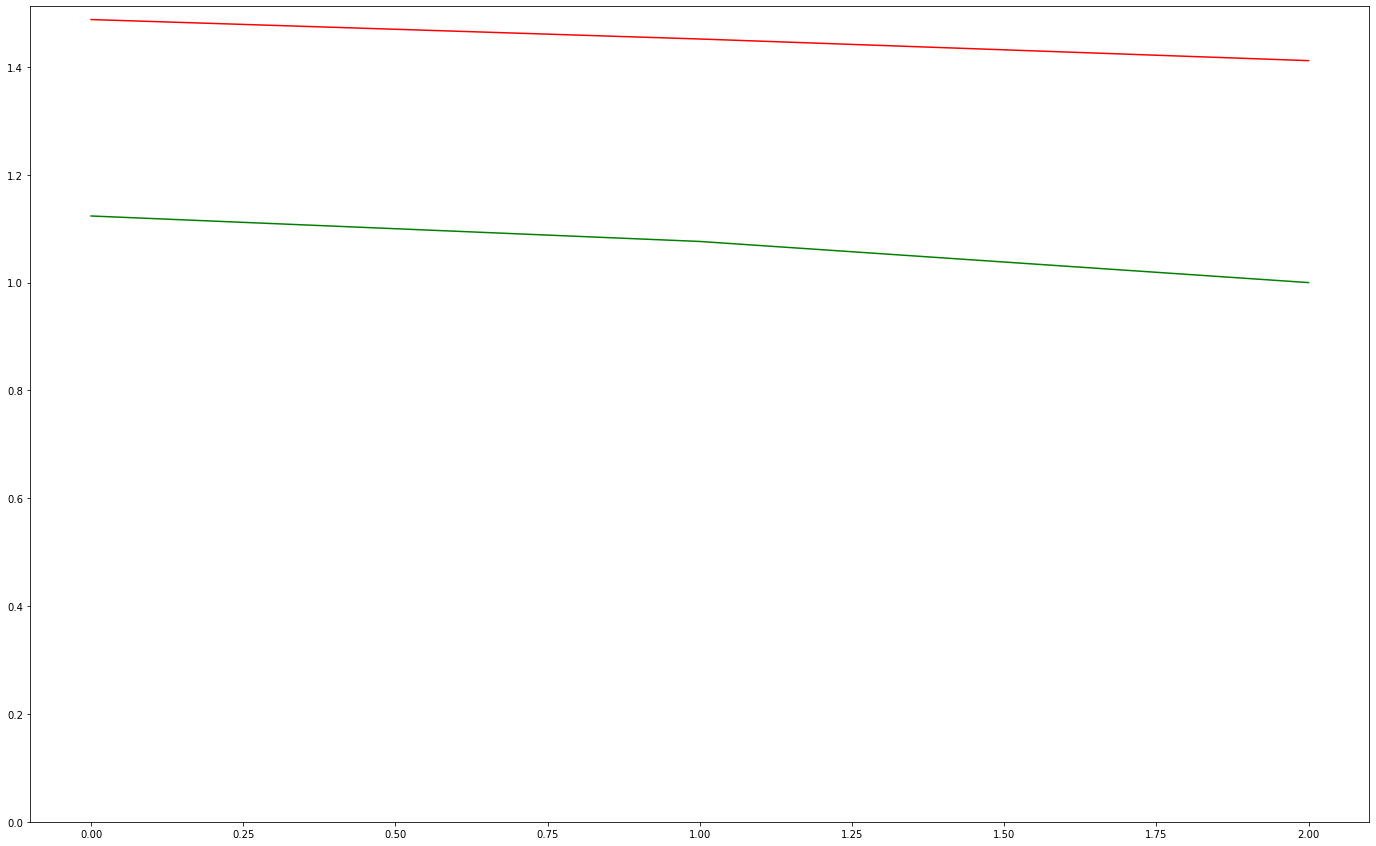

Train Epoch: 14 [0/50000 (0%)]	Loss: 1.356644
Train Epoch: 14 [6400/50000 (13%)]	Loss: 1.377827
Train Epoch: 14 [12800/50000 (26%)]	Loss: 1.394344
Train Epoch: 14 [19200/50000 (38%)]	Loss: 1.229154
Train Epoch: 14 [25600/50000 (51%)]	Loss: 1.101261
Train Epoch: 14 [32000/50000 (64%)]	Loss: 1.464541
Train Epoch: 14 [38400/50000 (77%)]	Loss: 1.176998
Train Epoch: 14 [44800/50000 (90%)]	Loss: 1.397490

Test set: Average loss: 1.0021, Accuracy: 6752/10000 (68%)



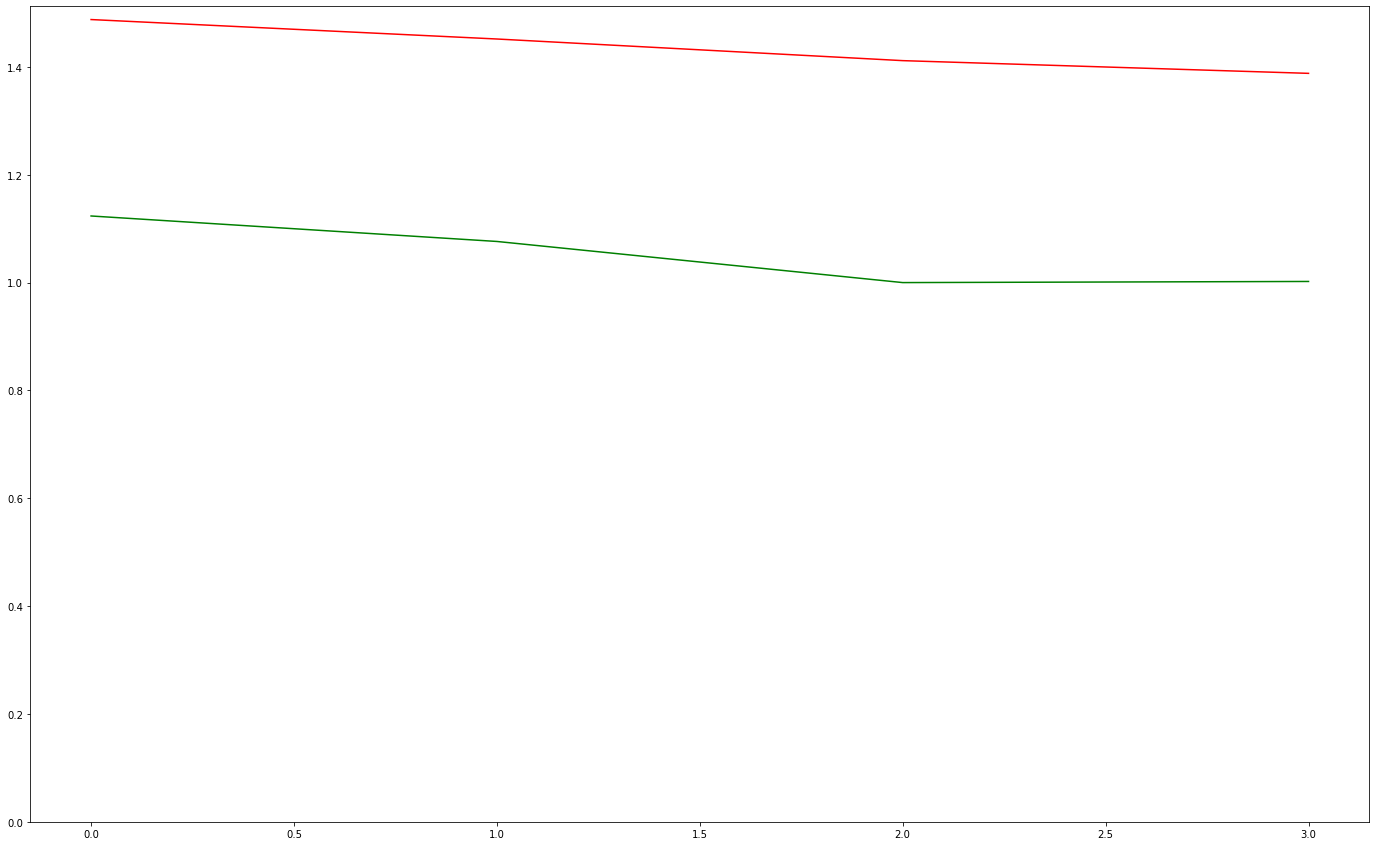

Train Epoch: 15 [0/50000 (0%)]	Loss: 1.266582
Train Epoch: 15 [6400/50000 (13%)]	Loss: 1.584299
Train Epoch: 15 [12800/50000 (26%)]	Loss: 1.561836
Train Epoch: 15 [19200/50000 (38%)]	Loss: 1.152108
Train Epoch: 15 [25600/50000 (51%)]	Loss: 1.315864
Train Epoch: 15 [32000/50000 (64%)]	Loss: 1.450187
Train Epoch: 15 [38400/50000 (77%)]	Loss: 1.379886
Train Epoch: 15 [44800/50000 (90%)]	Loss: 1.424431

Test set: Average loss: 0.9491, Accuracy: 6853/10000 (69%)



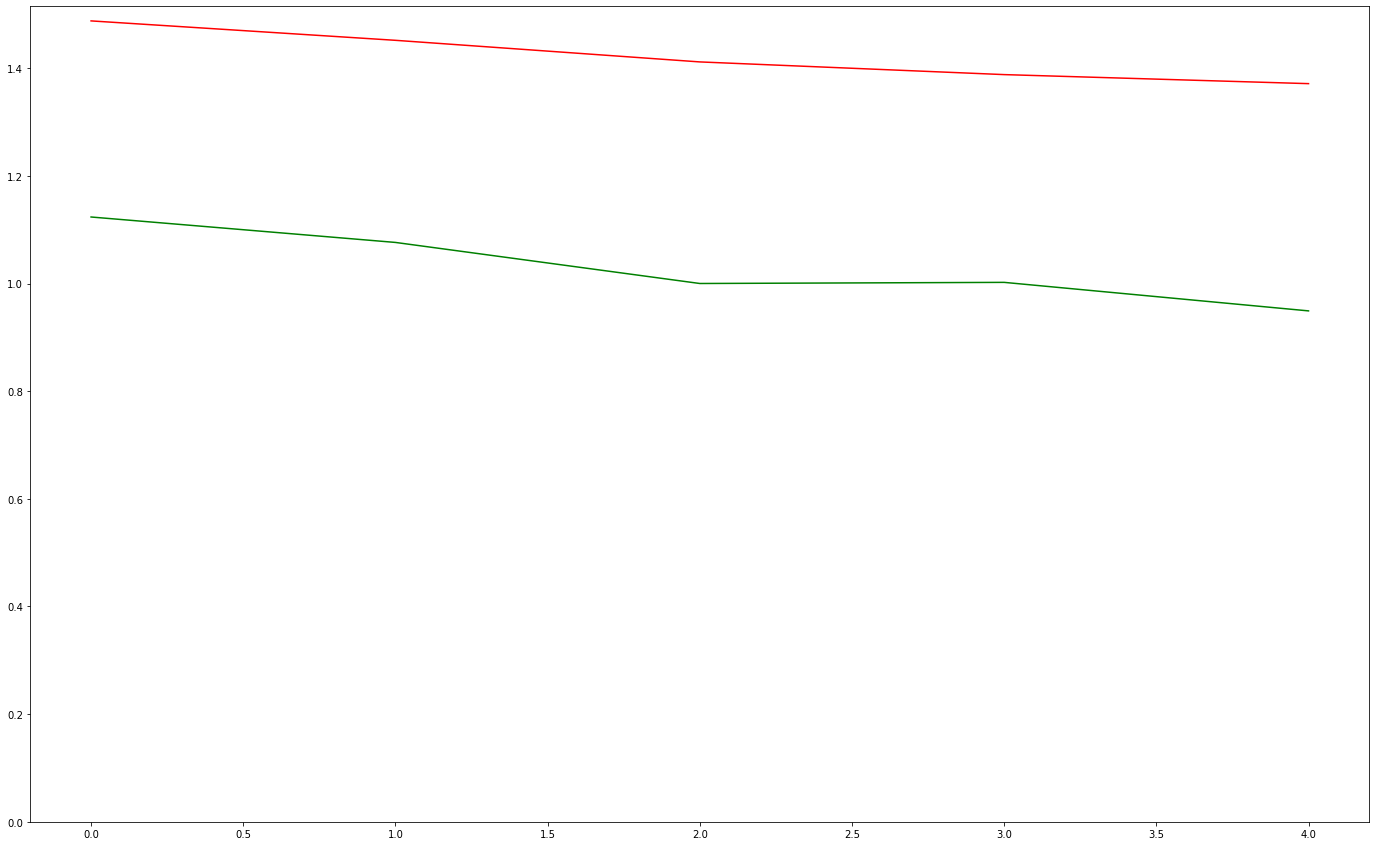

In [8]:
model = torch.load("cifar_first_10_epochs.pth")
epochs          = 15
lr              = 0.25
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(11, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    
    test(model, device, test_loader, test_loss)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)

torch.save(model, "cifar_first_15_epochs.pth")

Train Epoch: 11 [0/50000 (0%)]	Loss: 1.720209
Train Epoch: 11 [6400/50000 (13%)]	Loss: 1.464601
Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.664878
Train Epoch: 11 [19200/50000 (38%)]	Loss: 1.607427
Train Epoch: 11 [25600/50000 (51%)]	Loss: 1.607056
Train Epoch: 11 [32000/50000 (64%)]	Loss: 1.468891
Train Epoch: 11 [38400/50000 (77%)]	Loss: 1.290287
Train Epoch: 11 [44800/50000 (90%)]	Loss: 1.395704

Test set: Average loss: 1.0542, Accuracy: 6756/10000 (68%)



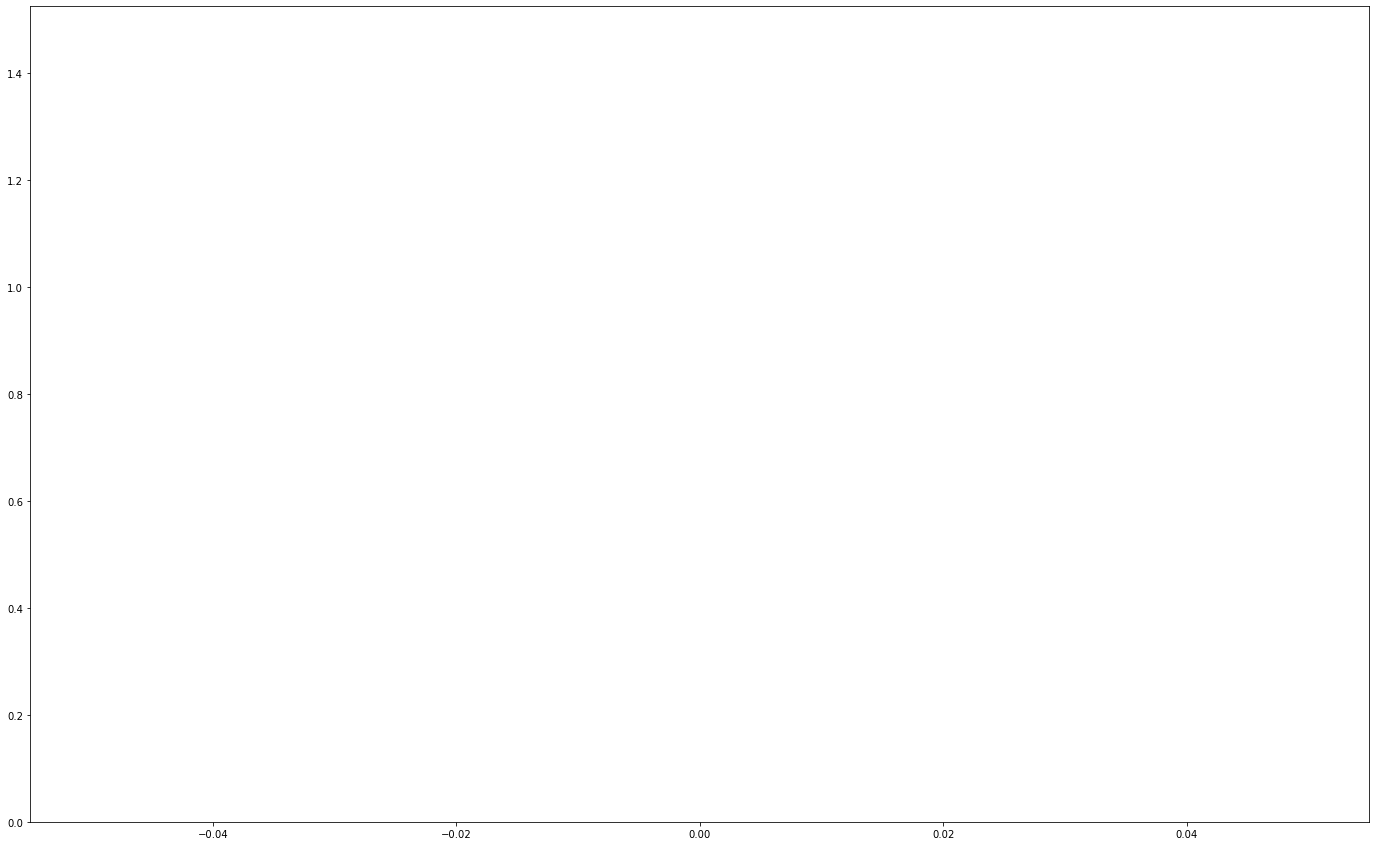

Train Epoch: 12 [0/50000 (0%)]	Loss: 1.406782
Train Epoch: 12 [6400/50000 (13%)]	Loss: 1.419040
Train Epoch: 12 [12800/50000 (26%)]	Loss: 1.579990
Train Epoch: 12 [19200/50000 (38%)]	Loss: 1.254941
Train Epoch: 12 [25600/50000 (51%)]	Loss: 1.357480
Train Epoch: 12 [32000/50000 (64%)]	Loss: 1.421574
Train Epoch: 12 [38400/50000 (77%)]	Loss: 1.455456
Train Epoch: 12 [44800/50000 (90%)]	Loss: 1.577580

Test set: Average loss: 1.0506, Accuracy: 6714/10000 (67%)



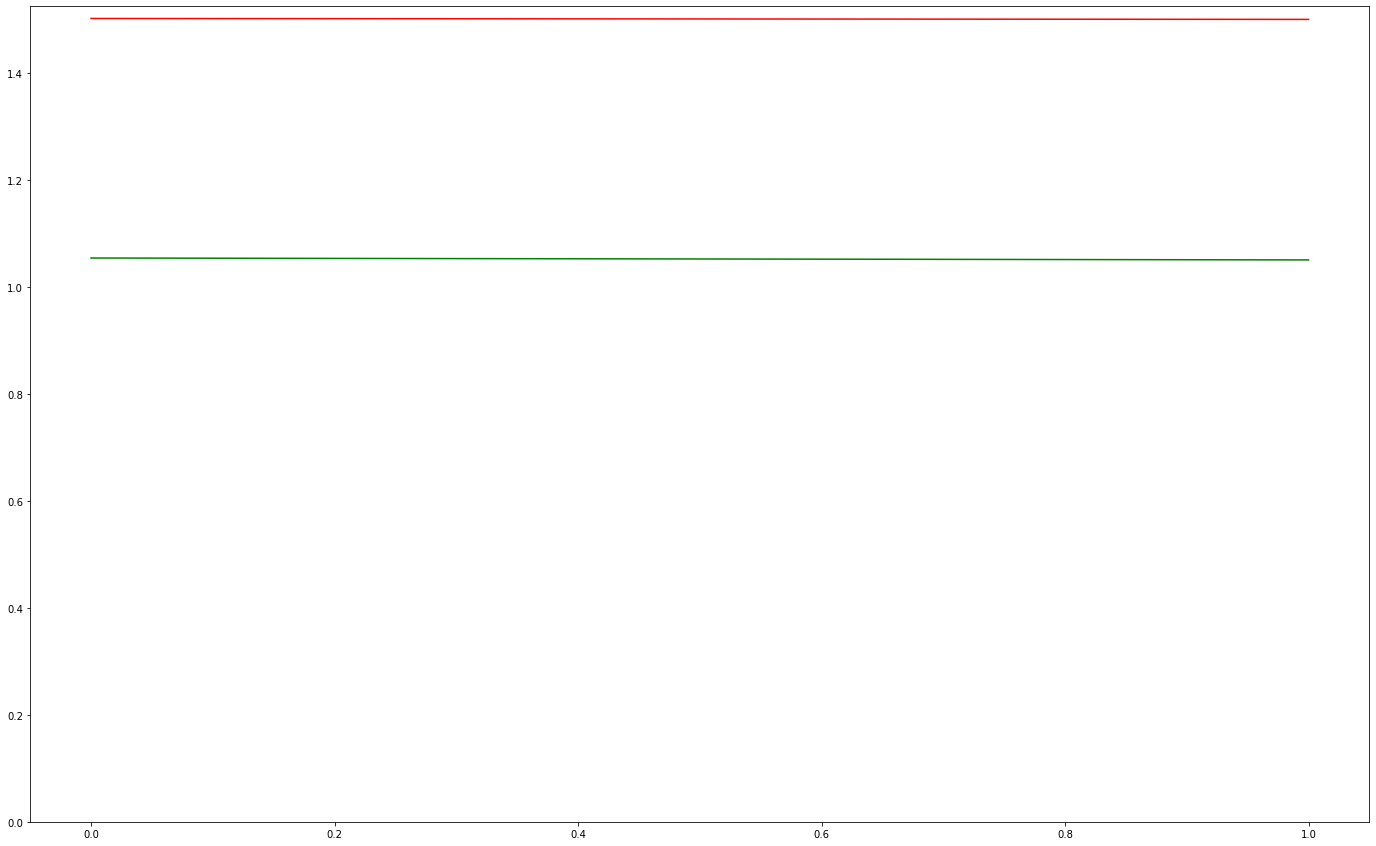

Train Epoch: 13 [0/50000 (0%)]	Loss: 1.174741
Train Epoch: 13 [6400/50000 (13%)]	Loss: 1.349783
Train Epoch: 13 [12800/50000 (26%)]	Loss: 1.506370
Train Epoch: 13 [19200/50000 (38%)]	Loss: 1.607899
Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.613110
Train Epoch: 13 [32000/50000 (64%)]	Loss: 1.435086
Train Epoch: 13 [38400/50000 (77%)]	Loss: 1.453412
Train Epoch: 13 [44800/50000 (90%)]	Loss: 1.205164

Test set: Average loss: 1.0438, Accuracy: 6748/10000 (67%)



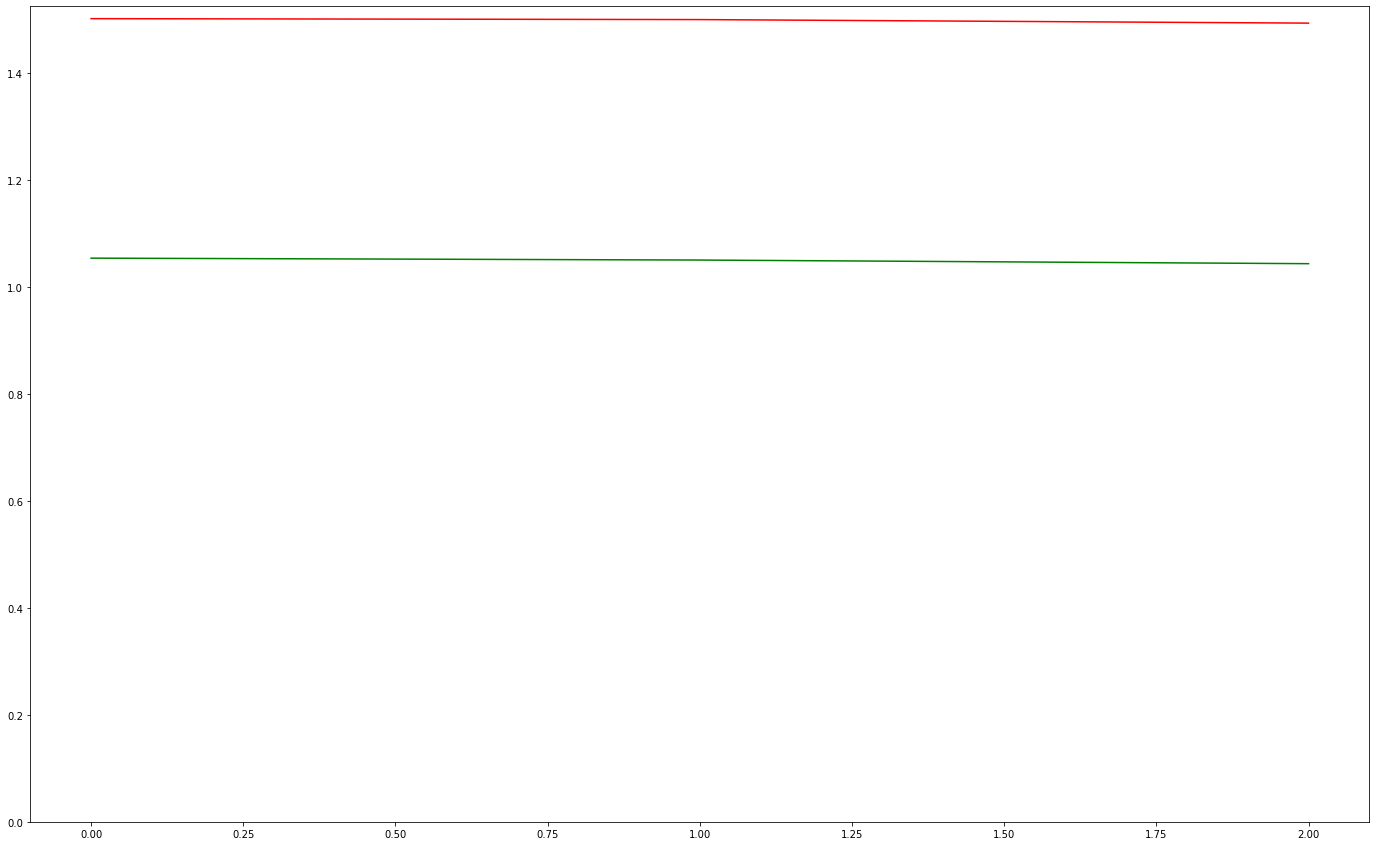

Train Epoch: 14 [0/50000 (0%)]	Loss: 1.400434
Train Epoch: 14 [6400/50000 (13%)]	Loss: 1.443574
Train Epoch: 14 [12800/50000 (26%)]	Loss: 1.509524
Train Epoch: 14 [19200/50000 (38%)]	Loss: 1.352933
Train Epoch: 14 [25600/50000 (51%)]	Loss: 1.159087
Train Epoch: 14 [32000/50000 (64%)]	Loss: 1.517624
Train Epoch: 14 [38400/50000 (77%)]	Loss: 1.340159
Train Epoch: 14 [44800/50000 (90%)]	Loss: 1.490812

Test set: Average loss: 1.0413, Accuracy: 6763/10000 (68%)



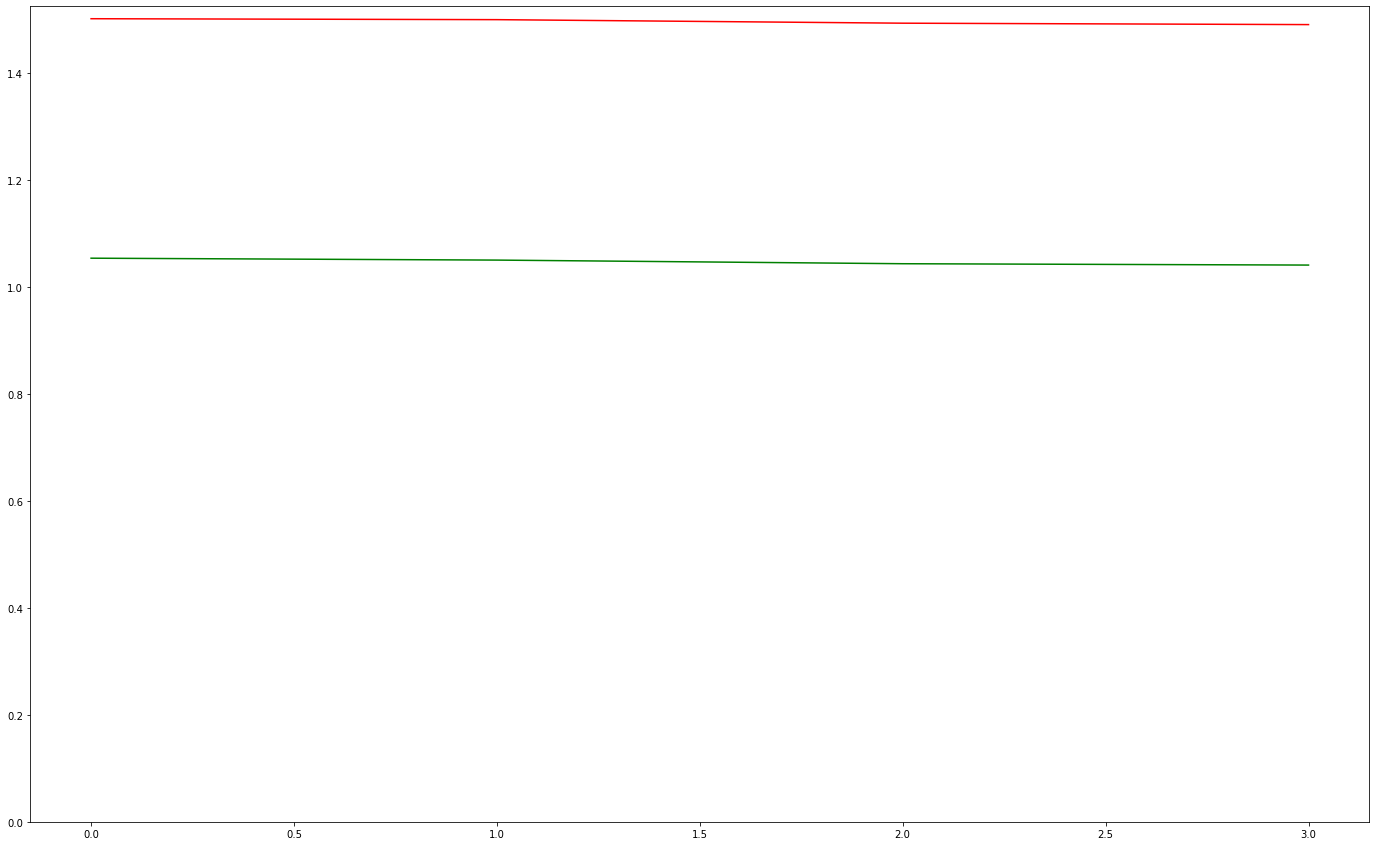

Train Epoch: 15 [0/50000 (0%)]	Loss: 1.384831
Train Epoch: 15 [6400/50000 (13%)]	Loss: 1.665545
Train Epoch: 15 [12800/50000 (26%)]	Loss: 1.618475
Train Epoch: 15 [19200/50000 (38%)]	Loss: 1.244434
Train Epoch: 15 [25600/50000 (51%)]	Loss: 1.473251
Train Epoch: 15 [32000/50000 (64%)]	Loss: 1.582268
Train Epoch: 15 [38400/50000 (77%)]	Loss: 1.461075
Train Epoch: 15 [44800/50000 (90%)]	Loss: 1.503642

Test set: Average loss: 1.0398, Accuracy: 6768/10000 (68%)



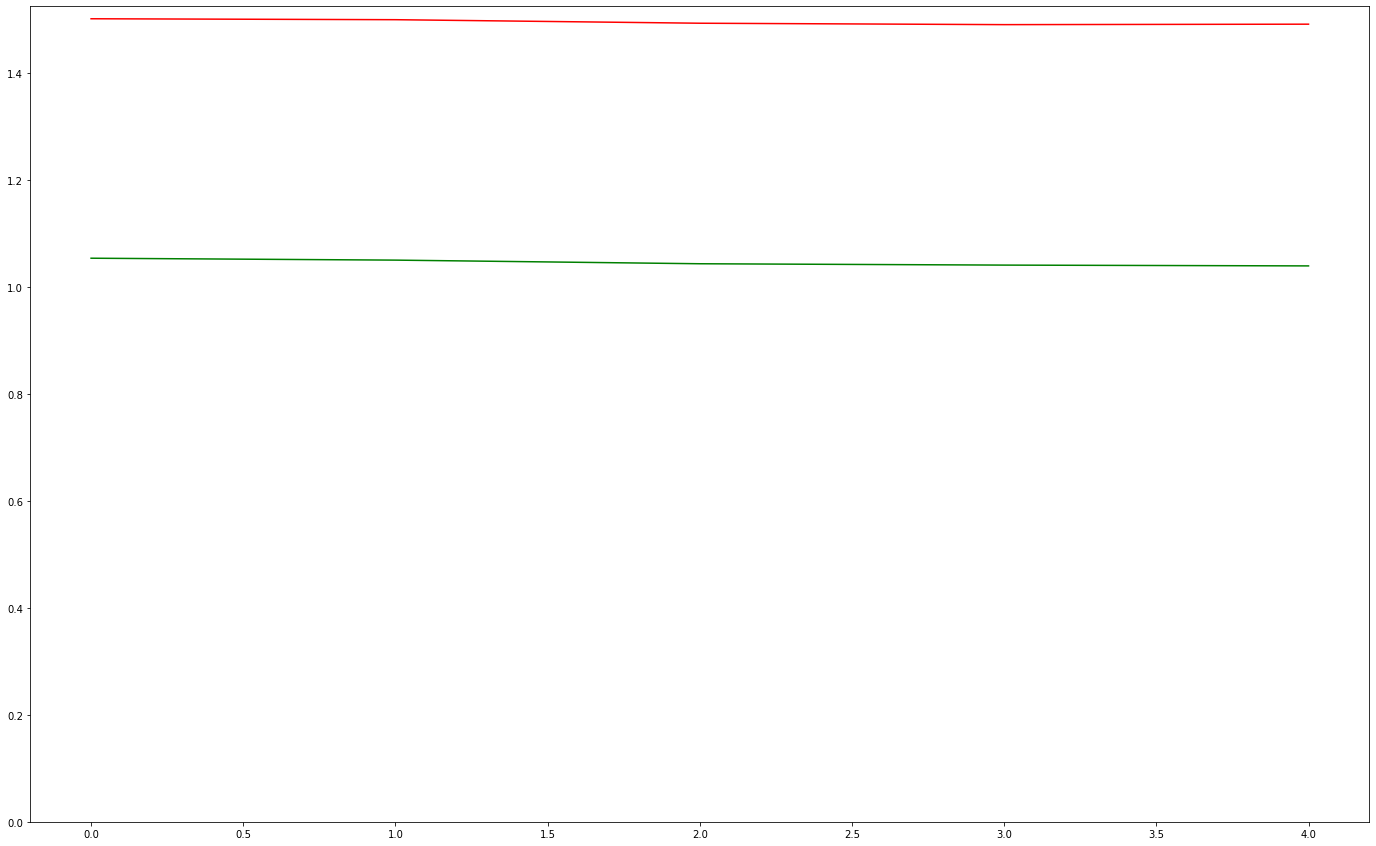

In [9]:
model = torch.load("cifar_first_10_epochs.pth")
epochs          = 15
lr              = 0.01
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(11, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    
    test(model, device, test_loader, test_loss)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)

torch.save(model, "cifar_first_15_epochs_slow.pth")